<a href="https://colab.research.google.com/github/smartinternz02/SBSPS-Challenge-10060-Slient-Speech-Recognition-Automatic-Lip-reading-Model-using-3D-CNN-and-GRU/blob/main/ibmchallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.5.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.2
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0


Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 88.8MB/s]


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
The vocabulary is:['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size=40)
tf.Tensor([1 2 3], shape=(3,), dtype=int64)

['./data/s1/bbal6n.mpg']
tf.Tensor(
[[[[ 1.460374  ]
   [ 1.460374  ]
   [ 1.4209044 ]
   ...
   [ 0.15787826]
   [ 0.19734783]
   [ 0.07893913]]

  [[ 1.460374  ]
   [ 1.460374  ]
   [ 1.4209044 ]
   ...
   [ 0.15787826]
   [ 0.07893913]
   [ 0.03946957]]

  [[ 1.4209044 ]
   [ 1.4209044 ]
   [ 1.3814349 ]
   ...
   [ 0.07893913]
   [ 0.07893913]
   [ 0.07893913]]

  ...

  [[ 0.9472696 ]
   [ 0.9472696 ]
   [ 0.9472696 ]
   ...
   [ 9.946331  ]
   [ 9.867392  ]
   [ 9.867392  ]]

  [[ 0.9472696 ]
   [ 0.9472696 ]
   [ 0.947

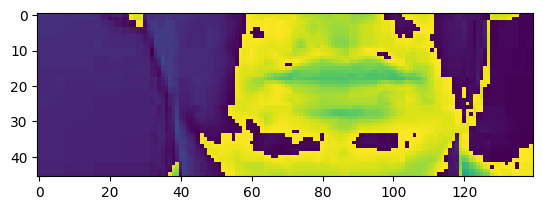

In [ ]:
!pip list

!pip install opencv-python matplotlib imageio gdown tensorflow


import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

tf.config.list_physical_devices('GPU')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

import gdown

url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')


def load_video(path:str)->List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret,frame=cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        # to extract lip
        # dlip used to extract part using that we get portion measurements
        frames.append(frame[190:236,80:220,:])
    cap.release()
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std
# each character we expect in video
vocab= [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
print(vocab)

char_to_num=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
# takes number convret to number
num_to_char=tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True
)
print(
    f"The vocabulary is:{char_to_num.get_vocabulary()} "
    f"(size={char_to_num.vocabulary_size()})"
)
# this convert to number
print(char_to_num(['a','b','c']))

# to load allignmnets
def load_alignments(path:str)->List[str]:
    with open(path,'r') as f:
        lines=f.readlines()
    tokens =[]
    for line in lines:
        line=line.split()
        if line[2]!='sil':
            tokens=[*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]


def load_data(path:str):
        path=bytes.decode(path.numpy())
        file_name=path.split('/')[-1].split('.')[0]
        video_path=os.path.join('data','s1',f'{file_name}.mpg')
        alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
        frames=load_video(video_path)
        alignments=load_alignments(alignment_path)
        return frames,alignments



test_path='./data/s1/bbal6n.mpg'

# test_path='.\\data\\s1\\bbal6n.mpg'
print(tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0])
print(tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\'))
frames,alignments=load_data(tf.convert_to_tensor(test_path))
print(frames)
print(plt.imshow(frames[0]))
plt.imshow(frames[0])



print(alignments)
print(num_to_char(alignments.numpy()))

print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))


import tensorflow as tf
from typing import Tuple  # Import the Tuple type

# Define your mappable_function to load data
def mappable_function(path:str) -> Tuple[tf.Tensor, tf.Tensor]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

from matplotlib import pyplot as plt
data=tf.data.Dataset.list_files('./data/s1/*.mpg')
data=data.shuffle(500)
# paths of each file
data=data.map(mappable_function)
# print(frames)
# alignments of each file under dataset
print(alignments)

data=data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data=data.prefetch(tf.data.AUTOTUNE)
frames,alignments = data.as_numpy_iterator().next()
# print(alignments)
test=data.as_numpy_iterator()
val=test.next();val[0]

sample = data.as_numpy_iterator()
val = sample.next()
fv = (val[0][0].astype(np.uint8) * 255).squeeze()
# converts into gif what he is saying
imageio.mimsave('./animation.gif', fv, duration=10)

from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler




print(data.as_numpy_iterator().next()[0][0].shape)











model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

model.summary()
yhat = model.predict(val[0])
yhat[0].shape
print(yhat)
print(tf.argmax(yhat[0],axis=1))

print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))
print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
print( model.input_shape)
print(model.output_shape)


# setup training options and train

def scheduler(epoch,lr):
    if epoch<30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)


In [7]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(data)
model.fit(data,epochs=2, callbacks=[checkpoint_callback, schedule_callback,example_callback])



Epoch 1/2
1/1 [==============================] - 2s 2s/step
Original: place green at d nine soon
Prediction: place gren at n nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red with x eight please
Prediction: place brue with x eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 487s 943ms/step - loss: 4.2862 - lr: 1.0000e-04
Epoch 2/2
1/1 [==============================] - 0s 211ms/step
Original: lay red at e two now
Prediction: lay red at e two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with x five again
Prediction: set gren with x five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 472s 945ms/step - loss: 6.4983 - lr: 1.00

In [10]:


# to make prediction
import gdown
url='https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output='checkpoints.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('checkpoints.zip','models')
model.load_weights('models/checkpoint')
test_data=data.as_numpy_iterator()
test_data.next()
sample=test_data.next()
yhat=model.predict(sample[0])
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75,75],greedy=True)[0][0].numpy()

print('~'*100,'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


# test on a video

sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

yhat = model.predict(tf.expand_dims(sample[0], axis=0))

real_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

print('~' * 100, 'REAL TEXT')
print(real_text)

print('~' * 100, 'PREDICTIONS')

predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

print(predictions)


Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 320MB/s]


1/1 [==============================] - 0s 282ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
1/1 [==============================] - 1s 1s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]
